$\textbf{Propagation Delay Calculation}$

$\text{In this tutorial we will see how to calculate the $t_0$ with the known sample}$

In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, tools, data_tools
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import widgets as wd


# if you want to save the picture the process takes too long
# For faster run put save_figure to False
save_figure = True

In [2]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [3]:
tdc, pulse_mode, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, pulse_mode, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

In [14]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))


variables.init()

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/t0_calibration/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]


data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['high_voltage (V)'].to_numpy()
if pulse_mode_ini == 'voltage':
    dld_pulseVoltage = data['pulse (V)'].to_numpy()
elif pulse_mode_ini == 'laser':
    dld_pulseVoltage = data['pulse (deg)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
dld_x = data['x (mm)'].to_numpy()
dld_y = data['y (mm)'].to_numpy()

In [15]:
data

,high_voltage (V),pulse (V),start_counter,t (ns),x (mm),y (mm),pulse_pi,ion_pp
0,2787.217041,2787.217041,20553.0,820.285380,4.329796,-18.178776,0.0,1.0
1,2787.217041,2787.217041,20571.0,858.697038,17.351020,27.284082,18.0,1.0
2,2787.217041,2787.217041,20831.0,824.626494,-0.700408,-24.259592,260.0,1.0
3,2787.217041,2787.217041,21005.0,817.206138,10.187755,-7.608980,174.0,1.0
4,2787.217041,2787.217041,22091.0,834.838056,-4.871020,-25.119184,1086.0,1.0
...,...,...,...,...,...,...,...,...
15738057,7543.612793,7543.612793,1102.0,535.170888,-1.114286,-26.488163,572.0,1.0
15738058,7543.612793,7543.612793,1338.0,534.992580,-4.329796,21.426122,236.0,1.0
15738059,7543.612793,7543.612793,1586.0,544.676076,30.658776,7.386122,248.0,1.0
15738060,7543.612793,7543.612793,1616.0,529.547328,18.847347,-1.687347,30.0,1.0


$\mathbf{\text{calculate the mc in two mode for laser and voltage atom probe:}}$<br><br>
$$\frac{m}{n} = k V_{dc}(\frac{t + t_{0}}{d})^{2} ,$$<br>
$\text{or:}$
$$\frac{m}{n} = k\alpha (V_{dc} + \beta V_{pulse})(\frac{t + t_{0}}{d})^{2} $$<br>

10-21-2022 11:08:12 | INFO | Selected Mode = count
10-21-2022 11:08:12 | INFO | Selected Mode = count
10-21-2022 11:08:12 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


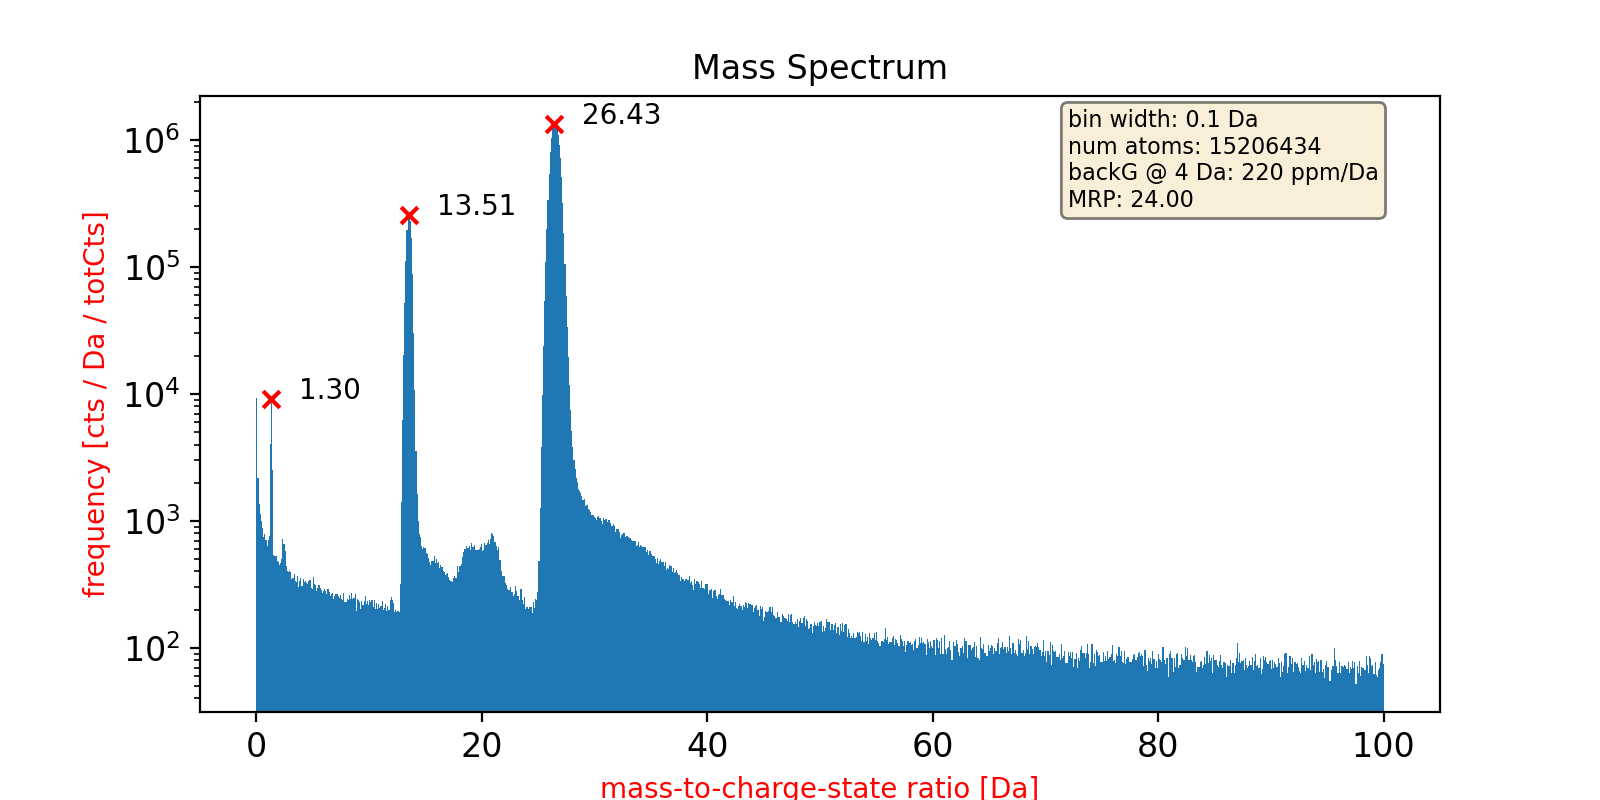

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [24.]
Peaks  0 is: 1.30 peak window sides are: 1.20 - 1.40
Peaks  1 is: 13.51 peak window sides are: 13.21 - 13.81
Peaks  2 is: 26.43 peak window sides are: 25.93 - 27.03


In [16]:
mc_seb = mc_tools.tof2mc(dld_t, t0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, percent=50, plot=True, prominence=500, fig_name=figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))

$\text{In the cell below you should type the correct m/c for the detected peak above}$

In [17]:
# The correct peak location based on your sample
peak_ideal = [1.01, 13.49, 26.98]

$\text{Here for each peak a mask will be created}$

In [19]:
pick_ions_plot = []

# creat mask for each peak base on the peak loc. and window size
for i in range(len(peaks_sides)):
    mask_tmp = np.logical_and((peaks_sides[i, 2] < mc_seb), (mc_seb < peaks_sides[i, 3]))
    if i == 0:
        lenght = len(mask_tmp[mask_tmp==True])

        indexes_mask_tmp_equal = np.where(mask_tmp==True)[0].tolist()
    else:    
        indexes_mask_tmp_equal = np.where(mask_tmp==True)[0].tolist()    
        indexes_mask_tmp_equal = np.random.choice(indexes_mask_tmp_equal, size=lenght, replace=False)
    
    
    bb = np.zeros(len(mc_seb))
    
    mc_seb_ideal_tmp = np.copy(bb)
    # put the location (mc) of the peak for all selected mc
    mc_seb_ideal_tmp[mask_tmp] = peak_ideal[i]
    
    pick_ions_plot.append(mask_tmp)
    if i == 0:
        mask = np.copy(mask_tmp)
        mc_seb_ideal = np.copy(mc_seb_ideal_tmp)
        mask_equal = indexes_mask_tmp_equal
    else:
        mask += mask_tmp
        mc_seb_ideal += mc_seb_ideal_tmp 
        mask_equal.extend(indexes_mask_tmp_equal)

$\text{The selcted peak ions in shown below}$

10-21-2022 11:08:57 | INFO | Selected Mode = count
10-21-2022 11:08:57 | INFO | Selected Mode = count
10-21-2022 11:08:57 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


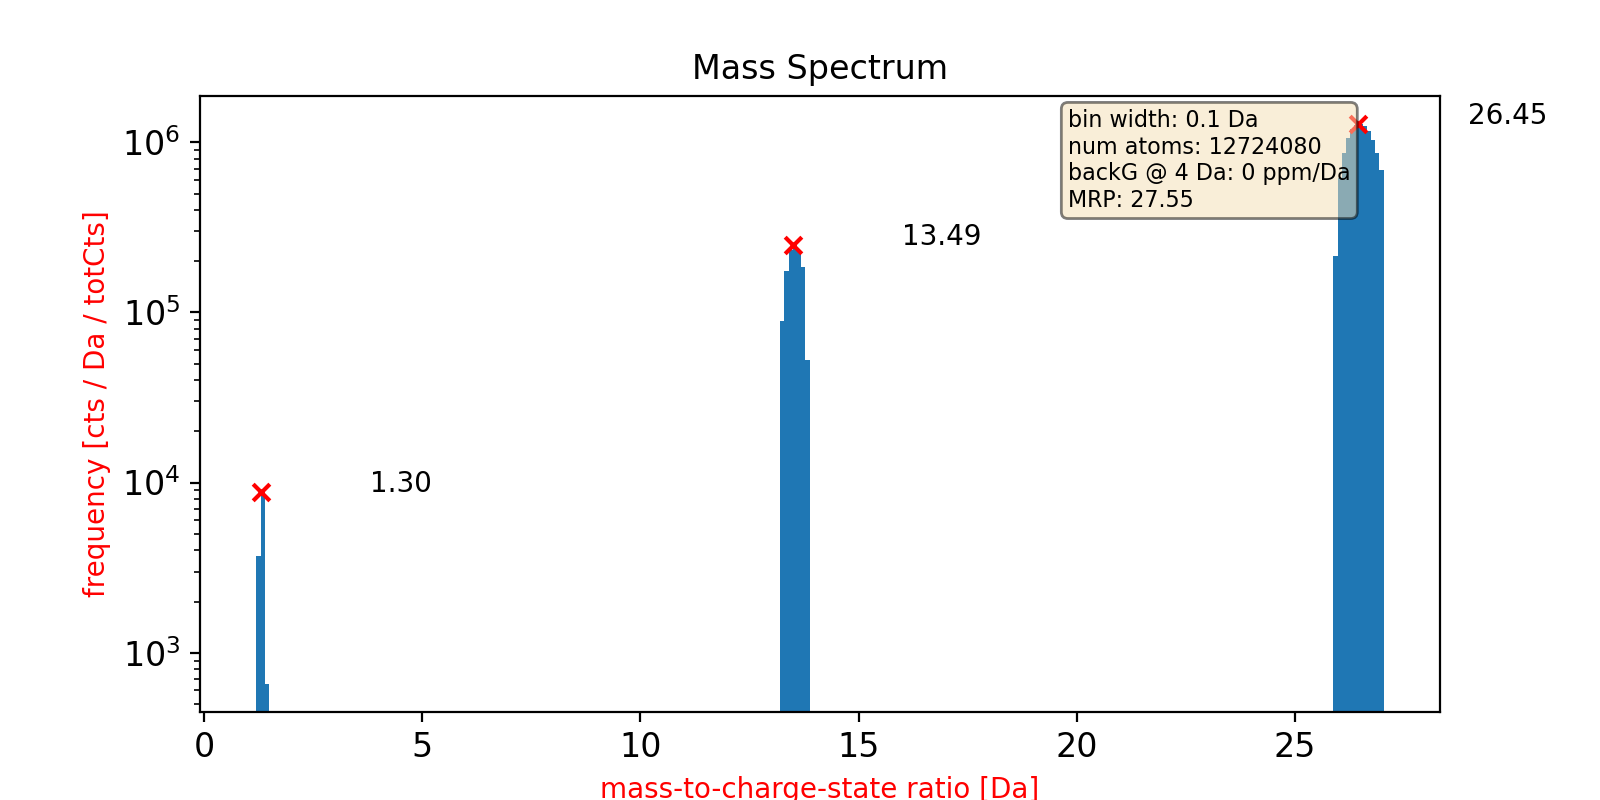

(array([26.45080038]),
 array([25.97077059, 26.93083017]),
 array([[1.29723941e+00, 8.80400000e+03, 1.29723941e+00, 1.29723941e+00,
         8.80400000e+03, 8.80400000e+03],
        [1.34899961e+01, 2.49250000e+05, 1.32019782e+01, 1.37780139e+01,
         8.94000000e+04, 5.26800000e+04],
        [2.64508004e+01, 1.28073100e+06, 2.59707706e+01, 2.69308302e+01,
         6.20351000e+05, 6.86762000e+05]]),
 [25.970770593963813, 26.834824215329558],
 263)

In [21]:
mc_seb_masked = mc_seb[mask]
tools.massSpecPlot(mc_seb_masked[mc_seb_masked < 100], 0.1, peaks_find=True, plot=True)

$\text{Plot ideal peak m/c:}$

10-21-2022 11:09:16 | INFO | Selected Mode = count
10-21-2022 11:09:16 | INFO | Selected Mode = count
10-21-2022 11:09:16 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


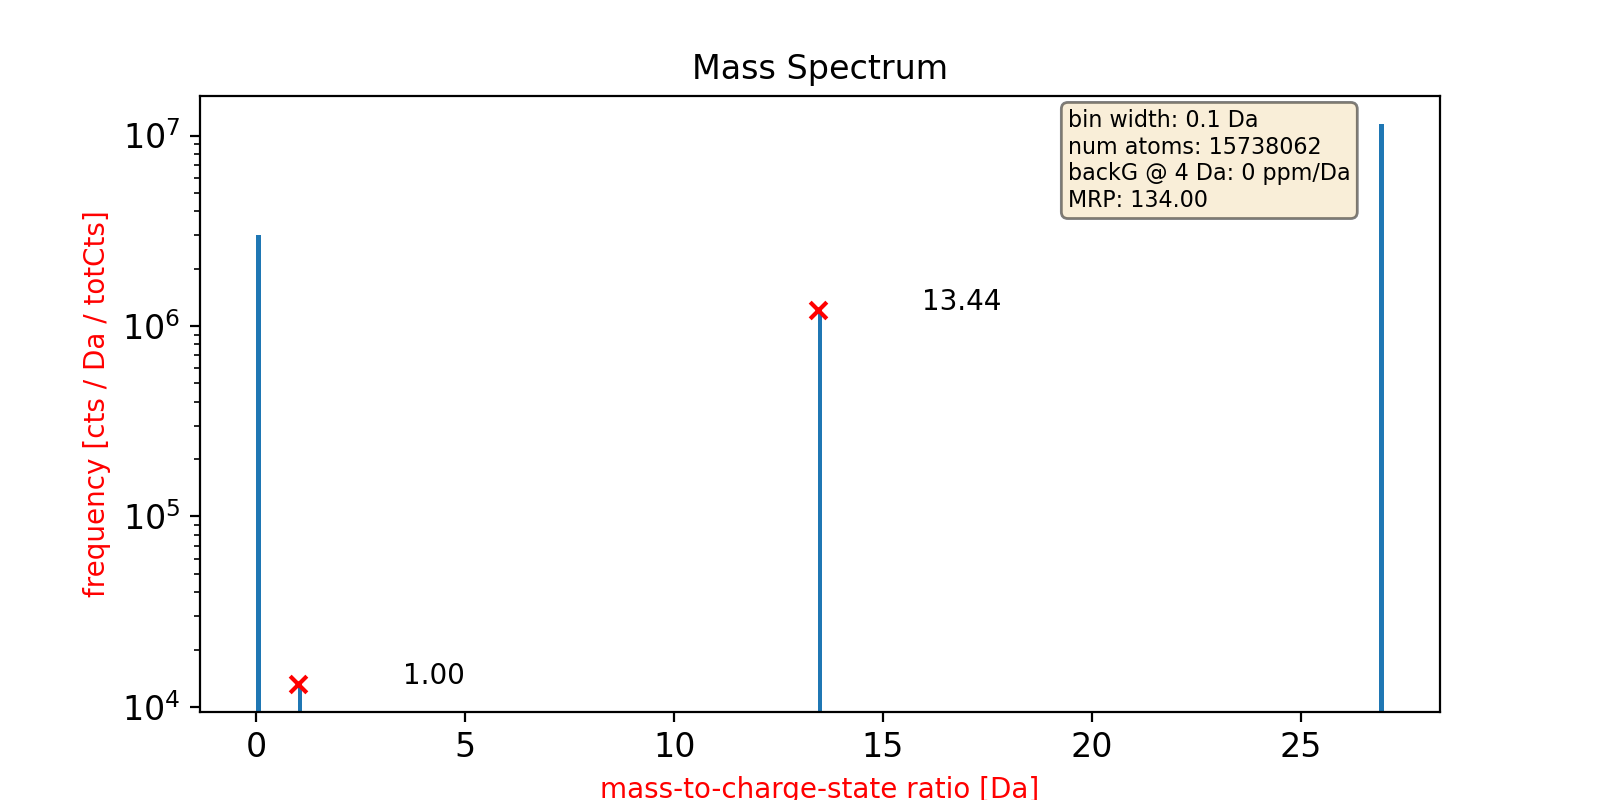

(array([26.8797026]),
 array([13.3395539, 13.5401487]),
 array([[1.00297398e+00, 1.31850000e+04, 9.02676580e-01, 1.10327138e+00,
         0.00000000e+00, 0.00000000e+00],
        [1.34398513e+01, 1.21467400e+06, 1.33395539e+01, 1.35401487e+01,
         0.00000000e+00, 0.00000000e+00]]),
 [13.339553903345724, 13.43985130111524],
 268)

In [23]:
tools.massSpecPlot(mc_seb_ideal, 0.1, peaks_find=True, plot=True)

$\text{Here we plot ions in each peak base on the TOF and (x,y) position}$

<IPython.core.display.Javascript object>


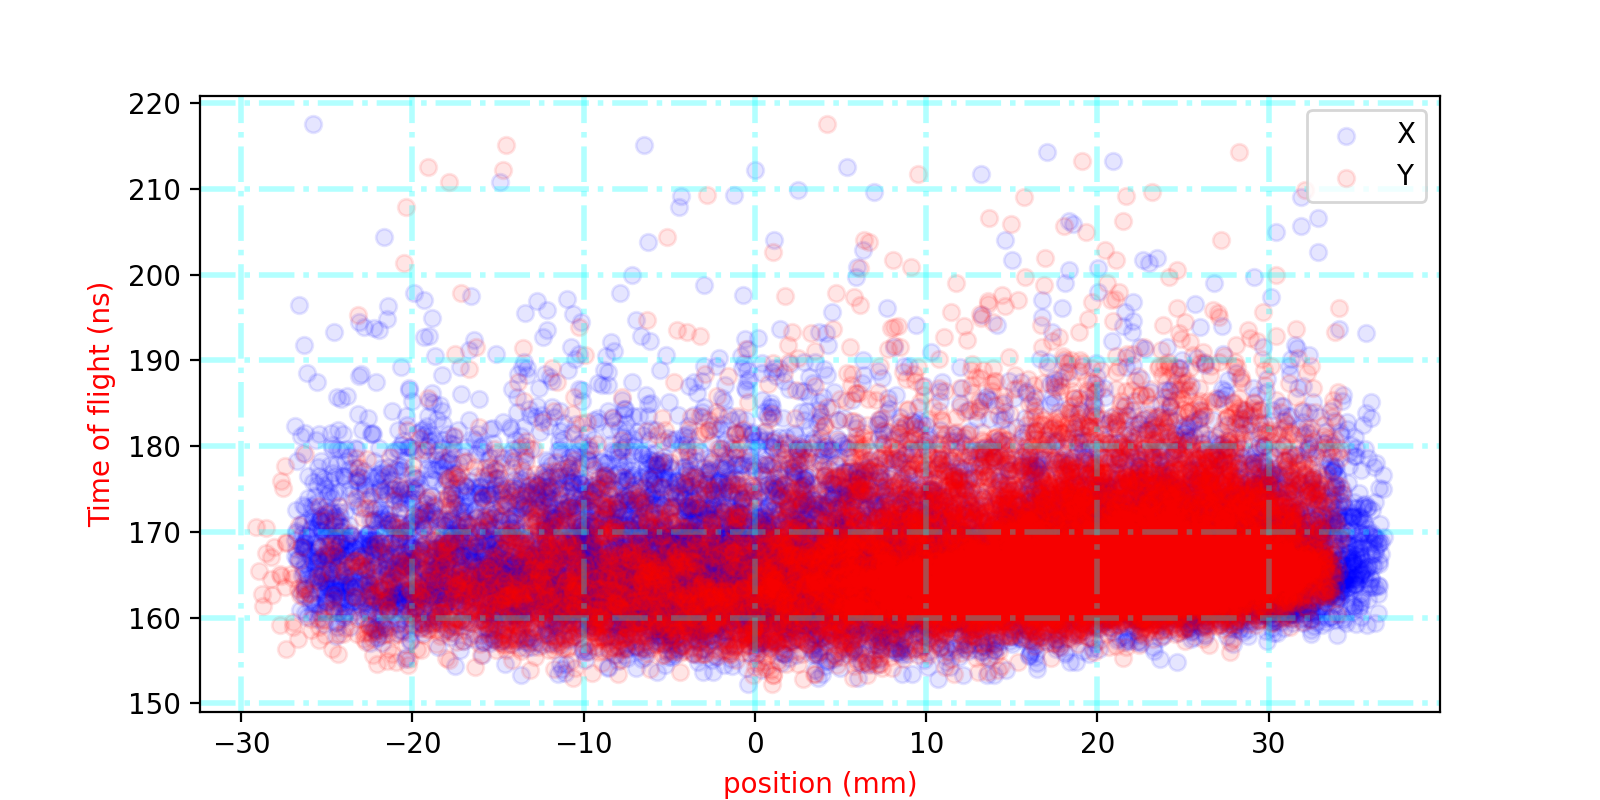

<IPython.core.display.Javascript object>


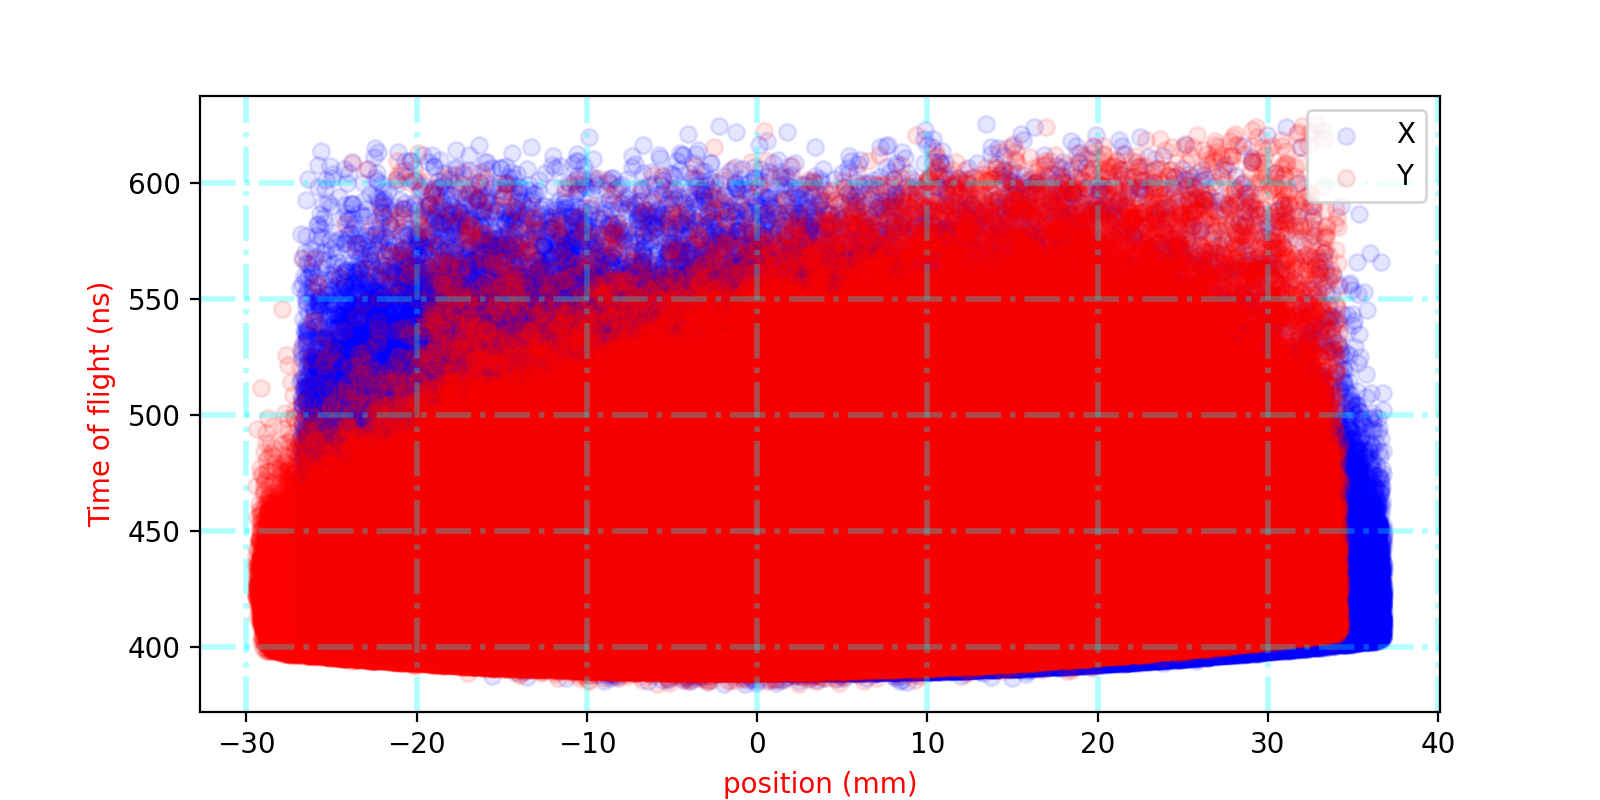

<IPython.core.display.Javascript object>


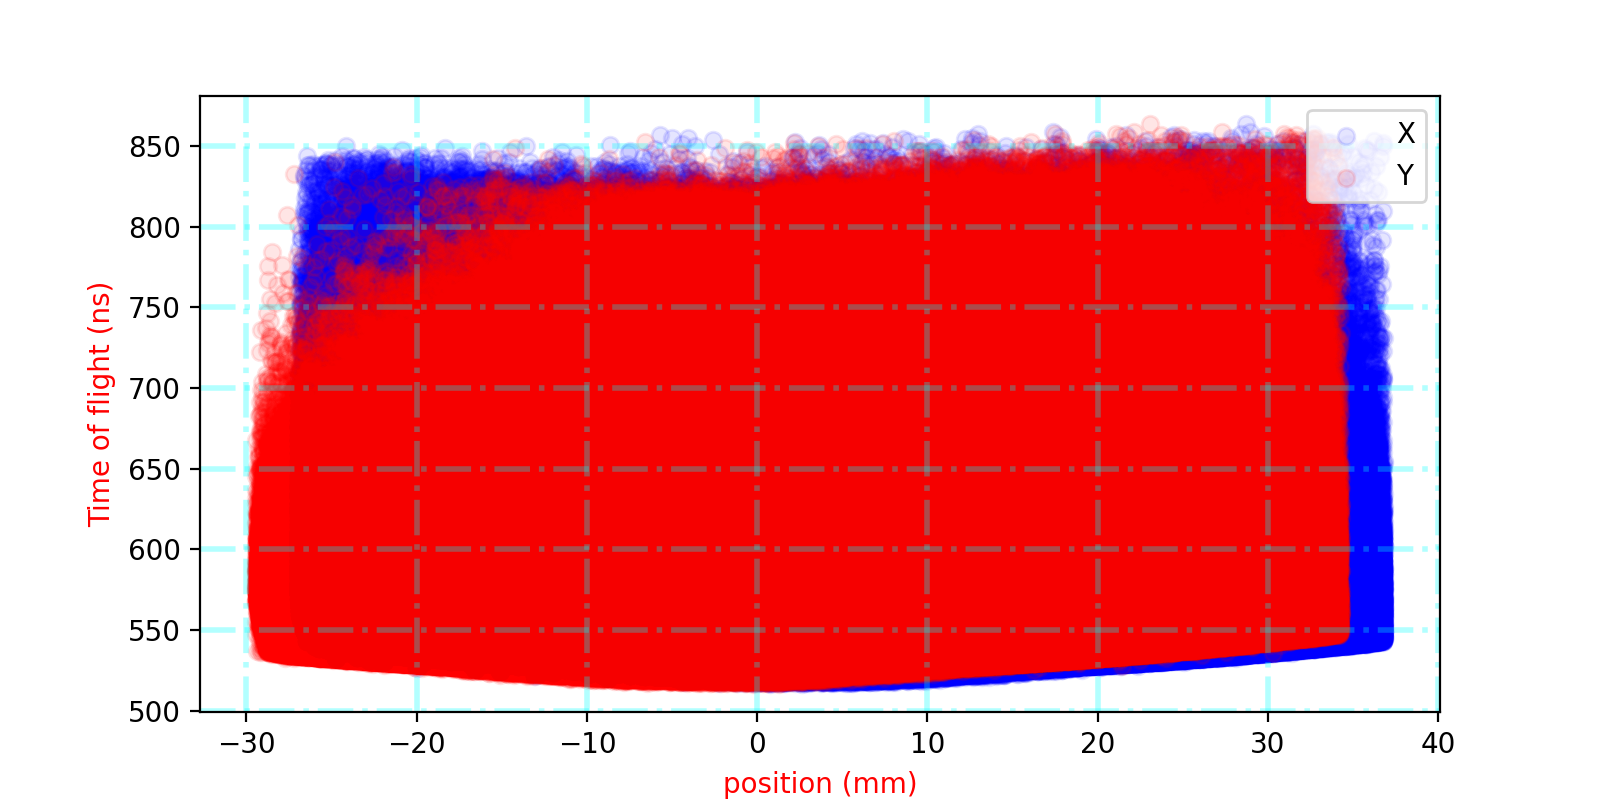

In [24]:
for i in range(len(pick_ions_plot)):
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    dld_x_masked = dld_x[pick_ions_plot[i]]
    dld_y_masked = dld_y[pick_ions_plot[i]]
    dld_t_masked = dld_t[pick_ions_plot[i]]
    x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
    y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("position (mm)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
    plt.legend(handles=[x, y], loc='upper right')
#     if save_figure == True:
#         plt.savefig(variables.result_path + '/position_peak_%s' %i + "%s.png" %figname, format="png", dpi=600)
    plt.show()

$\text{As you saw the TOF changes base on the (x,y) of the events. Therefore we creat a mask to only select the ions in center (4mm*4mm) of detector. This helps to cansel out the variation in TOF due to hit position}$

$\text{Reformulate the equation for volatege atom probe:}$<br>
$$t = d(\sqrt{\frac{\frac{m}{n}}{k\alpha (V_{dc}+\beta V_{pulse})}})-t_{0} $$<br>

<IPython.core.display.Javascript object>


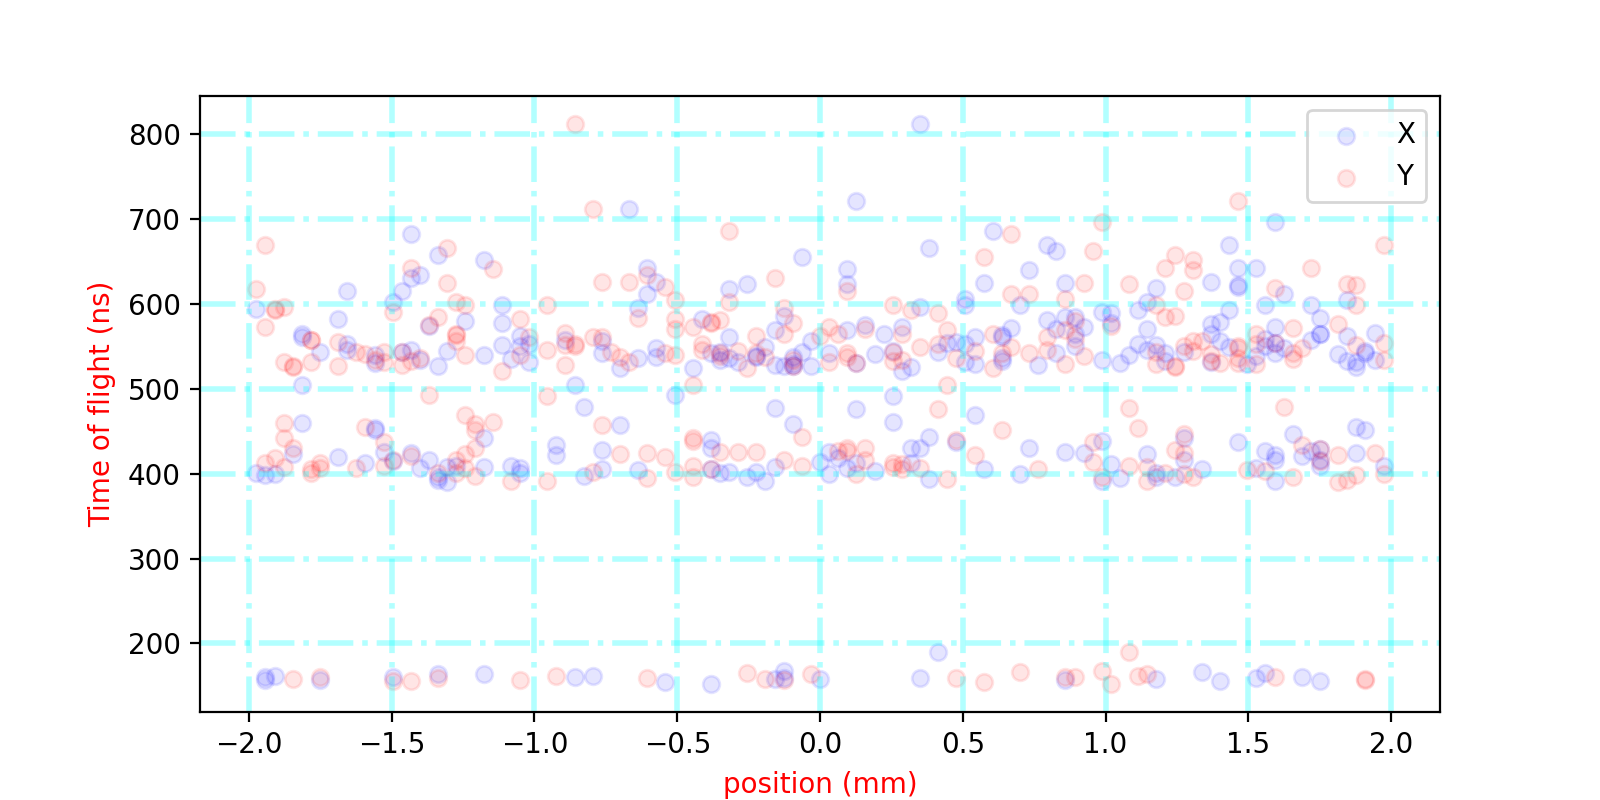

(290,)


In [25]:
# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 2mm * 2mm
detector_squre = 2
fig1, ax1 = plt.subplots(figsize=(8, 4))
dld_x_masked = dld_x[mask_equal]
dld_y_masked = dld_y[mask_equal]
dld_t_masked = dld_t[mask_equal]
dld_highVoltage_masked = dld_highVoltage[mask_equal]

mask_tmp_middle = np.logical_and((np.abs(dld_x_masked) < detector_squre), (np.abs(dld_y_masked) < detector_squre))
dld_x_masked = dld_x_masked[mask_tmp_middle]
dld_y_masked = dld_y_masked[mask_tmp_middle]
dld_t_masked = dld_t_masked[mask_tmp_middle]
dld_highVoltage_masked = dld_highVoltage_masked[mask_tmp_middle]

mc_seb_reg_masked = mc_seb_ideal[mask_equal]
mc_seb_reg_masked = mc_seb_reg_masked[mask_tmp_middle]

print(dld_t_masked.shape)
x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("position (mm)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[x, y], loc='upper right')
if save_figure == True:
    plt.savefig(variables.result_path + '/center_' + "%s.png" %figname, format="png", dpi=600)
#     plt.savefig(variables.result_path + '/center_' + "%s.svg" %figname, format="svg", dpi=600)
plt.show()


$\text{We calculate the t_0 base on:}$<br>
$$t_{0} = \frac{\sum_{n=1}^n{\left (t - L_{flight}  \sqrt{\frac{m/n}{2eV}} \right )}}{n}$$<br>

In [26]:
seb_t = dld_t_masked * 1E-9  # tof in s
# seb_factor = np.sqrt(mc_seb_reg_ideal[mask_middle] * 1.66E-27 / (2 * 1.6E-19 * 1.015 * (dld_highVoltage_masked + 0.7 * dld_pulseVoltage_masked)))
seb_factor = np.sqrt(mc_seb_reg_masked * 1.66E-27 / (2 * 1.6E-19 * dld_highVoltage_masked))

seb_factor = seb_factor * 1E6
seb_t = seb_t * 1E9

t0_seb_fixed = np.mean(np.array([seb_t]).squeeze(0) - (110 * np.array([seb_factor]).squeeze(0).reshape(-1, 1)))
print('Linear fixed path lenght -- the flight path lenght(slop): {:.2f}'.format(110), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_fixed), '(ns)')


Linear fixed path lenght -- the flight path lenght(slop): 110.00 (mm) 
the corrected t_0(intercept): 50.62 (ns)


In [27]:
t0_new = t0_seb_fixed

<IPython.core.display.Javascript object>


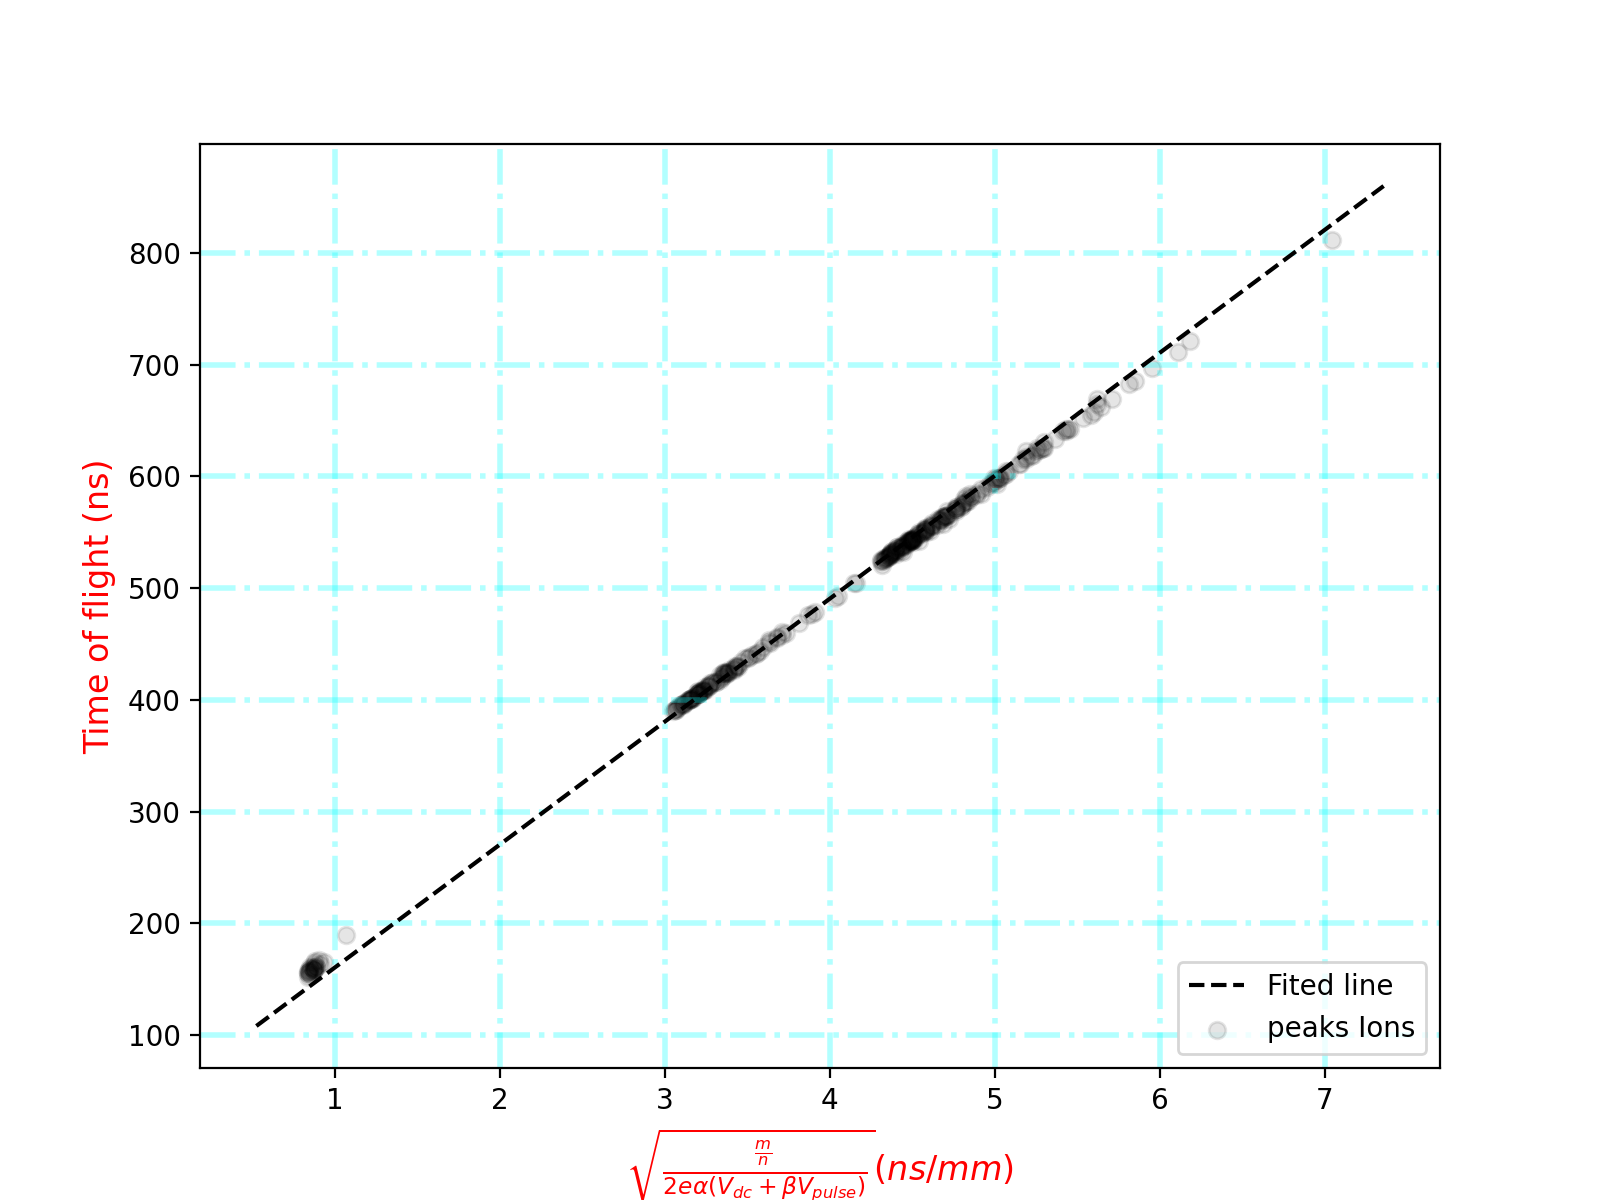

In [28]:
# Plot outputs
fig1, ax1 = plt.subplots(figsize=(8, 6))
peaks_data = plt.scatter(seb_factor, seb_t, color="black", label='peaks Ions', alpha=0.1)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())

linear_fix, = plt.plot(x_vals, t0_seb_fixed + 110 * x_vals, '--', color='black', label='Fited line' )

plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[linear_fix, peaks_data], loc='lower right')

ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=12)

ax1.set_xlabel(r"$\sqrt{\frac{\frac{m}{n}}{2e \alpha (V_{dc} + \beta V_{pulse})}} (ns/mm)$", color="red", fontsize=12)
if save_figure == True:
    plt.savefig(variables.result_path + '/regression' + "%s.svg" %figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + '/regression' + "%s.png" %figname, format="png", dpi=600)
plt.show()

$\text{Plot the m/c with new ${t_0}$ :}$<br>

10-21-2022 11:17:23 | INFO | Selected Mode = count
10-21-2022 11:17:23 | INFO | Selected Mode = count
10-21-2022 11:17:23 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


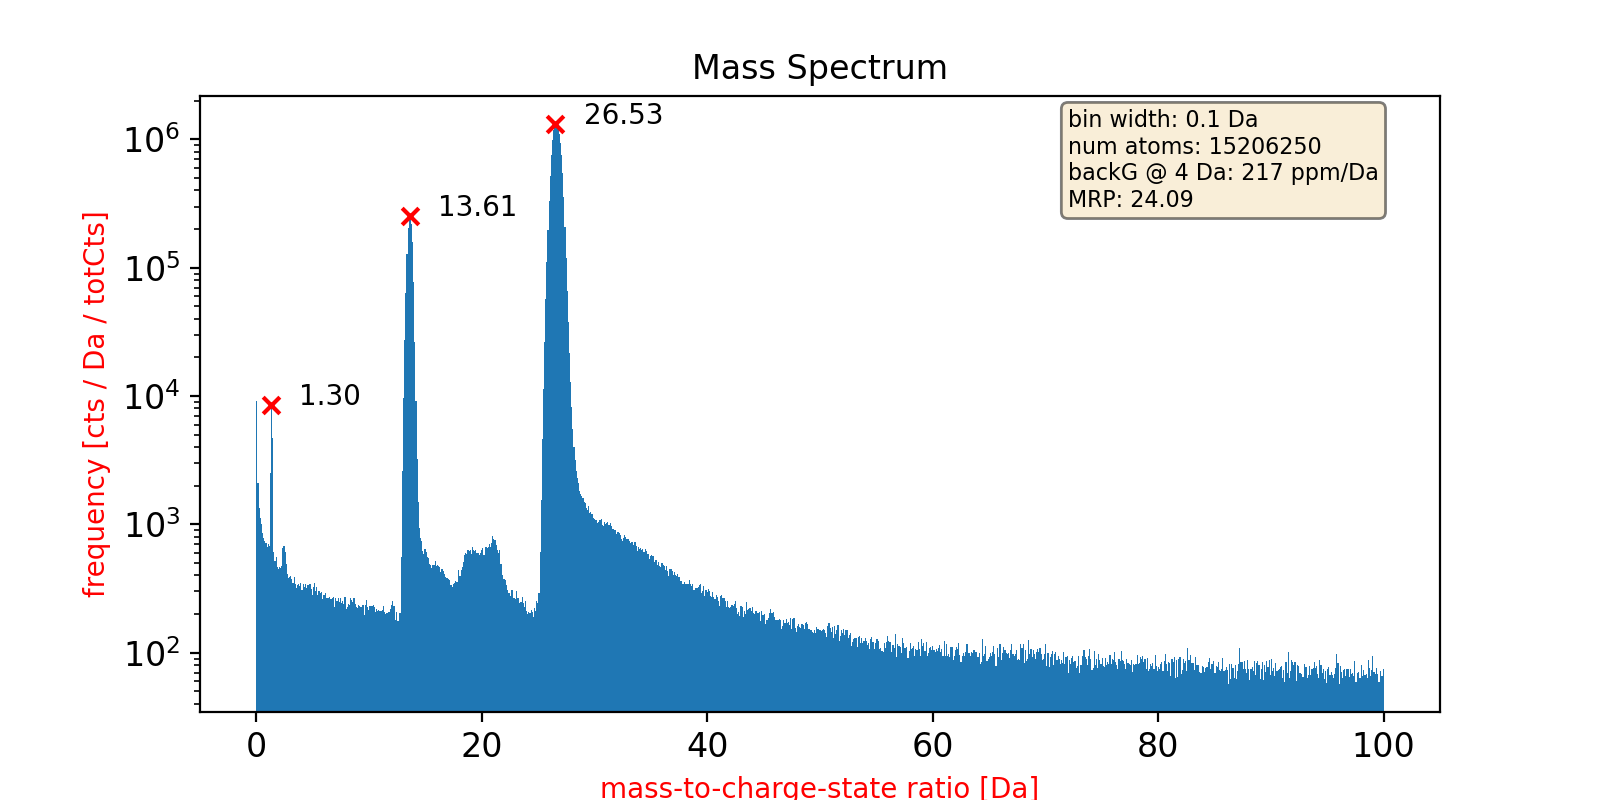

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [24.09090909]
Peaks  0 is: 1.30 peak window sides are: 1.20 - 1.50
Peaks  1 is: 13.61 peak window sides are: 13.21 - 13.91
Peaks  2 is: 26.53 peak window sides are: 26.03 - 27.13


In [29]:
# calculate the mc with new flight path lenght and t_0
mc_seb = mc_tools.tof2mc(dld_t, t0_new, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength)

max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, percent=50, plot=True, prominence=500, distance=None, fig_name='corrected_'+figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))